In [3]:
import os, cv2, pickle, subprocess, re, numpy as np
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

In [4]:
# Carica e restituisce un np.array contenente tutti i frame connessi
def load_frames(input_path):
    all_files = [f for f in os.listdir(input_path) if os.path.isfile(os.path.join(input_path, f))]

    frames = []
    for frame_file in all_files:
        frame_path = os.path.join(input_path, frame_file)
        frame = cv2.imread(frame_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame.flatten())  

    return np.array(frames)

# Train and return svd model trained on data
def train_svd_model(frames, n_components):
    svd = TruncatedSVD(n_components = n_components)
    svd.fit(frames)
    return svd

# Compress and save data
def apply_svd(svd_model, frames, original_shape, names):
    compressed_frames = svd_model.transform(frames)
    serialize_svd(original_shape, compressed_frames, names, '../results/SVD/')
    
# Serialize data into bytes file
def serialize_svd(original_shape, compressed_data, frame_names, output_path):
    data_to_save = {
        'compressed_data': compressed_data,
        'original_shape': original_shape,
        'frame_names': frame_names,
    }
    with open(output_path + 'compressed_data.pkl', 'wb') as f:
        pickle.dump(data_to_save, f)
        
# Deserialize data into orginal format
def deserialize_svd(input_path):
    with open(input_path, 'rb') as f:
        data = pickle.load(f)
    return data['compressed_data'], data['original_shape'], data['frame_names']

# Load received frames and save
def transform_and_save(svd_object, frames, original_shape, frame_names):
    reconstructed_frames = svd_object.inverse_transform(frames)
    
    os.makedirs("../results/SVD/decoder_output/", exist_ok = True)
    
    for i, frame in enumerate(reconstructed_frames):
        frame_reshaped = frame.reshape(original_shape).astype(np.uint8) 
        save_path = os.path.join("../results/SVD/decoder_output/", frame_names[i])
        cv2.imwrite(save_path, cv2.cvtColor(frame_reshaped, cv2.COLOR_RGB2BGR))


# Simulation Section

In [ ]:
# Encoder simulation

dataset_name = "Blob"
n_components = 35
train_input_path = "../pca_datasets/train/" + dataset_name + "/"

compact_frames = load_frames(train_input_path)

all_files = [f for f in os.listdir(train_input_path) if os.path.isfile(os.path.join(train_input_path, f))]
sample_frame = cv2.imread(os.path.join(train_input_path, all_files[0]))
original_shape = sample_frame.shape

svd_object = train_svd_model(compact_frames, n_components)

test_input_path = "../pca_datasets/test/" + dataset_name + "/"
test_names = [f for f in os.listdir(test_input_path) if os.path.isfile(os.path.join(test_input_path, f))]
test_frames = load_frames(test_input_path)

apply_svd(svd_object, test_frames, original_shape, test_names)

In [ ]:
# Decoder simulation

dataset_name = "Blob"
input_path = "../pca_datasets/test/" + dataset_name + "/"
output_path = "../results/PCA/" + dataset_name + "/"

frames_compressed, original_shape, names = deserialize_svd('../results/PCA/compressed_data.pkl')
transform_and_save(svd_object, frames_compressed, original_shape, names)

# Evaluation Section

In [5]:
def calculate_metrics(decompressed_path, original_path):  
    # Esegui il comando per calcolare SSIM usando ffmpeg
    ssim_result = subprocess.run(
        ["../../bin/ffmpeg", "-i", decompressed_path, "-i", original_path, "-lavfi", "ssim=stats_file=ssim_logfile.txt", "-f", "null", "-"],
        capture_output = True, text = True
    )
    
    # Esegui il comando per calcolare PSNR usando ffmpeg
    psnr_result = subprocess.run(
        ["../../bin/ffmpeg", "-i", decompressed_path, "-i", original_path, "-lavfi", "psnr=stats_file=psnr_logfile.txt", "-f", "null", "-"],
        capture_output = True, text = True
    )
    
    # Estrai il valore SSIM dal log
    ssim_match = re.search(r"All:([\d.]+)", ssim_result.stderr)
    ssim = float(ssim_match.group(1)) if ssim_match else None

    # Estrai il valore PSNR medio dal log
    psnr_match = re.search(r"average:([\d.]+)", psnr_result.stderr)
    #print(psnr_result.stderr)
    psnr = float(psnr_match.group(1)) if psnr_match else None
    
    return ssim, psnr


def plot_metrics(ssim_values, psnr_values, execution_times, compressed_sizes, svd_components):
    psnr_values = [0 if x is None else x for x in psnr_values]

    plt.figure(figsize=(12, 16))

    def annotate_values(x, y, ax):
        for i, val in enumerate(y):
            ax.text(x[i], y[i], f"{val:.2f}", fontsize=10, color="black", ha="right", va="bottom")

    # Grafico SSIM
    ax1 = plt.subplot(4, 1, 1)
    ax1.plot(svd_components, ssim_values, marker='o', color='blue', label='SSIM')
    plt.xticks(svd_components)
    plt.title("SSIM in base al numero di componenti SVD", fontsize=14)
    plt.xlabel("Numero di componenti SVD", fontsize=12)
    plt.ylabel("SSIM", fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=12)
    annotate_values(svd_components, ssim_values, ax1)

    # Grafico PSNR
    ax2 = plt.subplot(4, 1, 2)
    ax2.plot(svd_components, psnr_values, marker='s', color='orange', label='PSNR')
    plt.xticks(svd_components)
    plt.title("PSNR in base al numero di componenti SVD", fontsize=14)
    plt.xlabel("Numero di componenti SVD", fontsize=12)
    plt.ylabel("PSNR (dB)", fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=12)
    annotate_values(svd_components, psnr_values, ax2)

    # Grafico Tempo di Esecuzione
    ax3 = plt.subplot(4, 1, 3)
    ax3.plot(svd_components, execution_times, marker='^', color='green', label='Tempo di Esecuzione')
    plt.xticks(svd_components)
    plt.title("Tempo di esecuzione in base al numero di componenti SVD", fontsize=14)
    plt.xlabel("Numero di componenti SVD", fontsize=12)
    plt.ylabel("Tempo di esecuzione (s)", fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=12)
    annotate_values(svd_components, execution_times, ax3)

    # Grafico Dimensione del File Compresso
    ax4 = plt.subplot(4, 1, 4)
    ax4.plot(svd_components, compressed_sizes, marker='v', color='purple', label='Dimensione del File Compresso')
    plt.xticks(svd_components)
    plt.title("Dimensione del file compresso in base al numero di componenti SVD", fontsize=14)
    plt.xlabel("Numero di componenti SVD", fontsize=12)
    plt.ylabel("Dimensione (KB)", fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=12)
    annotate_values(svd_components, compressed_sizes, ax4)

    plt.tight_layout()
    plt.savefig("metrics_vs_svd_components_with_values.png")
    plt.show()


Testing SVD compression with 1 components...
Testing SVD compression with 11 components...
Testing SVD compression with 21 components...
Testing SVD compression with 31 components...
Testing SVD compression with 40 components...
Testing SVD compression with 50 components...
Testing SVD compression with 60 components...


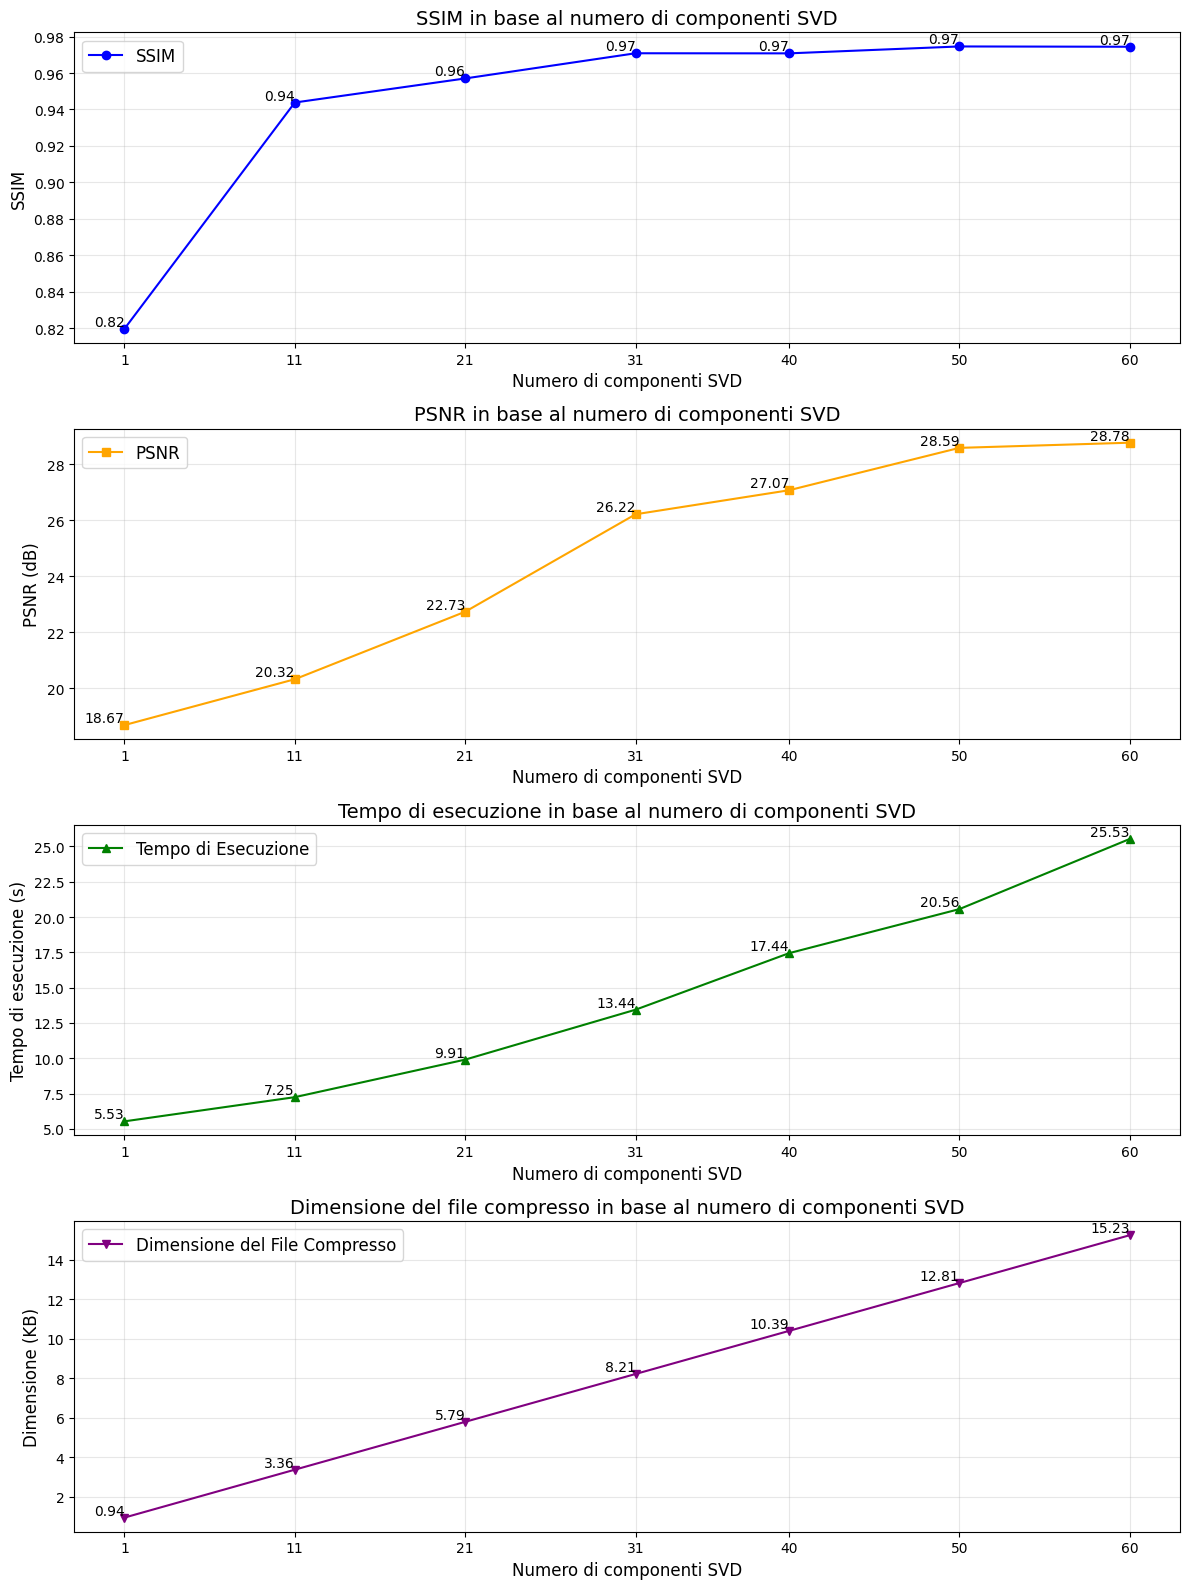

In [8]:
import time, os

dataset_name = "ArtGallery"
train_input_path = "../pca_datasets/train/" + dataset_name + "/"

number_of_files = len([f for f in os.listdir(train_input_path) if os.path.isfile(os.path.join(train_input_path, f))])
components_range = [round(x) for x in np.linspace(1, number_of_files, 8)]
components_range = components_range[:-1]


ssim_scores, psnr_scores, execution_times, sizes = [], [], [], []
for n_components in components_range:
        print(f"Testing SVD compression with {n_components} components...")
        
        # Simulate encoder
        start_time = time.time()
        compact_frames = load_frames(train_input_path)

        all_files = [f for f in os.listdir(train_input_path) if os.path.isfile(os.path.join(train_input_path, f))]
        sample_frame = cv2.imread(os.path.join(train_input_path, all_files[0]))
        original_shape = sample_frame.shape

        svd_object = train_svd_model(compact_frames, n_components)

        test_input_path = "../pca_datasets/test/" + dataset_name + "/"
        test_names = [f for f in os.listdir(test_input_path) if os.path.isfile(os.path.join(test_input_path, f))]
        test_frames = load_frames(test_input_path)

        apply_svd(svd_object, test_frames, original_shape, test_names)
        end_time = time.time()
        
        
        execution_times.append(end_time - start_time)
        sizes.append(os.path.getsize("/workspace/results/SVD/compressed_data.pkl") / 1024)
        

        # Simulate decoder
        frames_compressed, original_shape, names = deserialize_svd('../results/SVD/compressed_data.pkl')
        transform_and_save(svd_object, frames_compressed, original_shape, names)
    
        # Calcola SSIM e PSNR
        ssim, psnr = calculate_metrics("/workspace/results/SVD/decoder_output/" + names[0], "/workspace/pca_datasets/test/" + dataset_name + "/" + names[0])
        ssim_scores.append(ssim)
        psnr_scores.append(psnr)
        
plot_metrics(ssim_scores, psnr_scores, execution_times, sizes, components_range)